# Disciplina: Aprendizado Profundo para Visão Computacional (PPG TIG_Saúde)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/125WiQdaTP1wMFFLYlcsVTakPsRrlw7s_)

## Explainable Artificial Intelligence - XAI Techniques


# Técnica CAM
[Learning Deep Features for Discriminative Localization](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

CAM `(Class ACtivation Maps)` - Mapas de Ativação de Classe

O CAM é uma técnica que permite identificar as regiões que mais se destacam em uma imagem para uma determinada classe de interesse.

A ideia principal do CAM é que, após treinar uma CNN para classificar imagens em diferentes categorias, é possível utilizar os mapas de ativação gerados pela última camada convolucional da rede para obter uma representação da importância de cada região da imagem para a classificação final.

A técnica CAM, envolve pegar a saída da última camada convolucional e obter um vetor de características aplicando uma operação de pooling de média global. O vetor de características é então usado para calcular a predição final e o mapa de ativação de classe, que é obtido ponderando a saída da última camada convolucional com os pesos correspondentes da predição final.

https://keras.io/api/applications/xception/:

`avg pooling`: significa que o agrupamento de média global será aplicado à saída do último bloco convolucional e, portanto, a saída do modelo será um tensor 2D.

**  Class Ativation Maps(CAM)  somente CNNs que usam global average pooling**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import decode_predictions

# Modelo Pré-treinado Imagenet Xception (Exemplo François Chollet)

In [ ]:
model = keras.applications.xception.Xception(weights="imagenet")

In [ ]:
for layer in model.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_4
block2_pool
batch_normalization_4
add_12
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_5
block3_pool
batch_normalization_5
add_13
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_6
block4_pool
batch_normalization_6
add_14
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_15
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_16
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block

# Imagem retirada da Internet MNIST

![Imagem MNIST](https://meideru.com/wp-content/uploads/2017/02/mnist_pre4_cor8.jpg)

In [ ]:
img_path = keras.utils.get_file(
    fname = 'Mnist',
    #origin = 'https://conx.readthedocs.io/en/latest/_images/MNIST_6_0.png') # Imagem da Internet MNIST
    origin = 'https://meideru.com/wp-content/uploads/2017/02/mnist_pre4_cor8.jpg')

def get_img_array(img_path, target_size):
  """
    Carrega uma imagem do caminho especificado e a converte em um array pré-processado.

    Args:
        img_path (str): O caminho da imagem a ser carregada.
        target_size (tuple): O tamanho de destino para redimensionamento da imagem.

    Returns:
        numpy.ndarray: O array pré-processado da imagem.
  """
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = keras.applications.xception.preprocess_input(array)
  return array

img_array = get_img_array(img_path, target_size=(299, 299))

6688/6688 [==============================] - 0s 0us/step


In [ ]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  tape.watch(last_conv_layer_output)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]
  heatmap = np.mean(last_conv_layer_output, axis=-1)

(-0.5, 9.5, 9.5, -0.5)

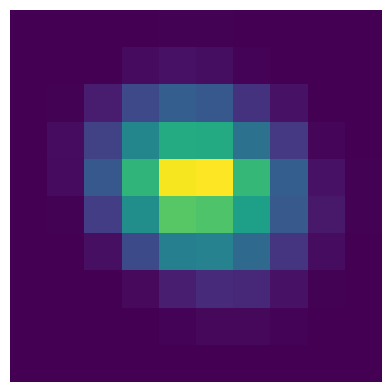

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.axis('off')

In [ ]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet") #https://matplotlib.org/stable/tutorials/colors/colormaps.html
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = 'Mnist_CAM.jpg'
superimposed_img.save(save_path)

<ipython-input-40-1986cfc49912>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



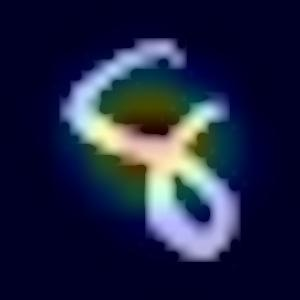

In [ ]:
from IPython.display import Image
display(Image(filename='Mnist_CAM.jpg', width = 400))

# Mapas de Ativação

## Técnica Grad-Cam
### Referência [Grad-Cam](https://arxiv.org/abs/1610.02391), proposed by _[Ramprasaath R. Selvaraju](https://arxiv.org/search/cs?searchtype=author&query=Selvaraju%2C+R+R), [Michael Cogswell](https://arxiv.org/search/cs?searchtype=author&query=Cogswell%2C+M), [Abhishek Das](https://arxiv.org/search/cs?searchtype=author&query=Das%2C+A), [Ramakrishna Vedantam](https://arxiv.org/search/cs?searchtype=author&query=Vedantam%2C+R), [Devi Parikh](https://arxiv.org/search/cs?searchtype=author&query=Parikh%2C+D), [Dhruv Batra](https://arxiv.org/search/cs?searchtype=author&query=Batra%2C+D)_.



A técnica Grad-CAM (Gradient-weighted Class Activation Mapping) é uma abordagem para visualizar as regiões importantes de uma imagem que influenciam as decisões de uma rede neural convolucional (CNN). Essa técnica é particularmente útil para entender quais áreas da imagem estão sendo relevantes para a classificação feita pela CNN.

A ideia básica por trás do Grad-CAM é gerar um mapa de ativação que destaca as regiões da imagem que são mais relevantes para a classificação realizada pela CNN. Isso é feito calculando o gradiente da saída desejada em relação às ativações da última camada convolucional da rede. Esse gradiente é então ponderado pela importância dessas ativações e usado para gerar o mapa de ativação.


**Técnica Pode ser usada em qualquer arquitetura**


4386/4386 [==============================] - 0s 0us/step


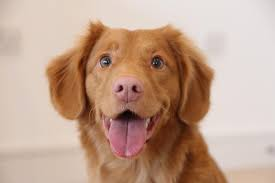

In [ ]:
# Referência: https://keras.io/examples/vision/grad_cam/


import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception # Baixa modelo pré-treinado Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "dog.jpg", "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRga28YpBbOzEHk-CnVLCXn-cB5jsHzIPkgoQ&usqp=CAU"
)

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



1/1 [==============================] - 5s 5s/step
Predicted: [('n02099601', 'golden_retriever', 6.282346), ('n02101388', 'Brittany_spaniel', 6.093024), ('n02099849', 'Chesapeake_Bay_retriever', 5.8333545)]


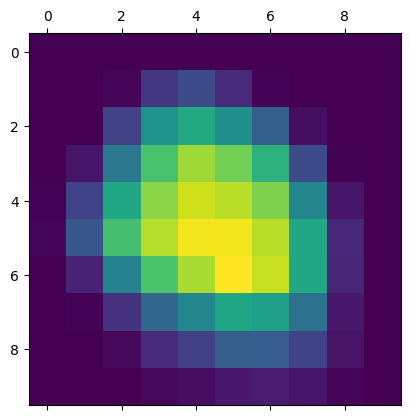

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=3)[0]) # Top3 da imagenet

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-13-8a3df7f2985d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


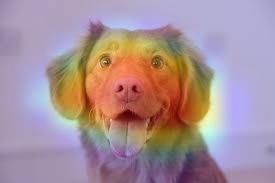

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

5290/5290 [==============================] - 0s 0us/step

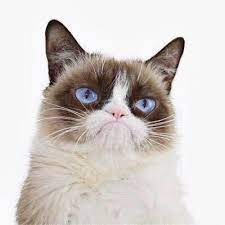

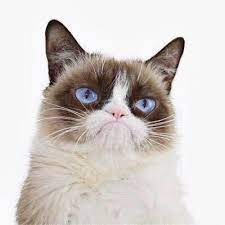

In [ ]:
# Referência: https://keras.io/examples/vision/grad_cam/


import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception # Baixa modelo pré-treinado Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file("Grumpy_cat.jpg", "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgVFRYYGBgaHBgYGRgYGBgYGhocGhgcGhgYGhgcJC4lHB4rHxgYJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHhISHjQkISQ0NDE0MTQ0MTQxNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0ND00NDQxNDQ/NDE0ND80NDUxP//AABEIAOEA4QMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAAAQIDBAUGBwj/xAA+EAABAwIDBgQDBwIEBwEAAAABAAIRAyEEEjEFQVFhcYEGIpGhMrHwBxNCUsHR4RTxYoKSwjNTcnOTorJD/8QAGAEBAQEBAQAAAAAAAAAAAAAAAAECAwT/xAAiEQEBAQEAAgICAgMAAAAAAAAAARECITESQQNRBGETInH/2gAMAwEAAhEDEQA/APX0IQgEIQgEqRKgEIQgEiVCBEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgVITFylC5j7R9puw+z6z2mHvApNPAvOUkdG5j2Qcltr7Wwyq5mGoioxpgve4tD4NywATGtyum8JePcPjSKZmlX/5byPNzY7R3TXlvXjGzdky2Y/ZS4nA5SCLOaQWuBgtIuCDqCCsfJ0nPh9IIXCfZ54y/qmnD4ggYmmLHQVWj8YH5hvHMHp3q3uxizDUiVCIRCIQgEIQgEIQgEIQgEJUIEQlSIBCEIBCEIBCEIBCEIBKUiUoHLgvthpzgAfy1qR6yHN/3ey71cb9qYnAO/7lL/7Uvpefbz3Z7Gim0b43KDEgG7RPSB36KGtismUAwIGnRFSu0gAny8ADJJ/my5e3bMZb3OY9lWmctRjg9jheCDb66r3bwf4jZjcO2oIa9sNqs/K8C8f4TqDwXiFegDBbAIixifa0HXVT+GdtPwWIFdsljhlqsH42TqB+ZpuD1G9b5uM9TX0OhVsDjmVmMqU3B7HgOa4aEFWV0cjUJyFAxCVCBEqEIBCcmkoBVsfjadFhfVe1jRq5xgdBxPJZfirxPRwTMz5c9wOSk343kb+TRvK8g2pj6+Nf95iXSPwMbIYwHcBv6nVZ66xrnnXow+0/AmoGTUgmM5ZDNYnWY5wu1BXzNtykGtMCIBHsvo7ZDC2hSBuRTpgzrIYJlObp1zi2hKkWmQhCEAhCEAhCEAlSJUChcr9pdMu2fVgTldTcegqNn5rqgqO2sGK2Hq0jo9j29yLHsYPZL6WPn6rSL2yZAtuJ04ELV2fshzjna8E/mE2J3ZSCPmqWz8Y4NIdlaRvtbiVr0McAQ3MHEn4gB6AE3+axHW2lr7Dbc5uZEuseUGFlVMGA9oIzNNs0wYNnannoZWl/Wvzw5rXgGHfEDG4gzA9I48tVmz/ODqx0ETq1wBBHcWM8N0FGZcM8EY+tgnPYSalFwe/KNz2ug5J+EuAmNDrzXfO8WURlEmSzORGjYdHfy6c1yFLChj9xkH9nDpYEcMvNSlrB5hoGhnYTIP8AqA7hL1hZrt8NtdjzE8t8k2/v3C0G1gVwVLHgPzRcNsJuXZZ98oHZFfxNlMNMwcsza1iU+c+0+D0AGUq43ZPitvwPMmXXtvNvmrbPFLHEAau0+fqrOuafGunlKFzj9vRlMTPDl/b3UWG8R+cNcCBeXRYHzG3KG+6vyifGupXIeMvGdPBtyMipiHDy0wbC/wATyNBy1PqsTbfjOtWL6GEZk1a6s6CRpJYNBvEneuHbhy1xfGZ297pc4zvk3PXepev0vPP7SYVtSvX+/ruz1HmS5x0Goa1mjGAblpU8NBl4AEWJ4cgNSquFxDwZDuoIvwsZAhaFKpns50g6XOo4cFj/AK6SMPGbP/qMVRw7BIqPaDb8AILyejWlfQEcF5n9mmzg/EV8S4Tkiiwni7zPPpkC9MW56c+/eBIlSLTAQhCAQhCAQhCASlIlKByY8SI5FPSFUfMdQgPdTMkh7230JDyNeFlobPpu+8aASAIIBEzff0g9pVbbeENLG1aUwBUeW74BeS2fkuv2Ls4Max7okCOo3AnhY879Vzd/ptswrHsa8tyugA8QRbvvE8E8va0RqJJ+vkqmIx7WS0m26/7rErY1wMajssXr9JOWziMWLxw391muxsktncXD/KCfkHD0WLicTfXX6+u6jwOMggk/iB6GZB5Ka3mN52NyZXT8LHvHVrHhl/8AqhZrX5wI0G/9ucfNY2I2lBc0bs7b72kyAe5HopsNjbRN4N+pk6K3Ei3hsQXvET8UHoBH7+q0ml5a99xkIn/CRr7yq/g/D/ePLxoHgSfytlz3juGtHPougrYUfcPIAmplP+p0EA74utfCYl6ys7AbScYnl6z/AAt7B1RlJPCO5M/IFczhmAMduLZ3+m7qtHDYqKTGnVwLzymWsHo2e6xmG61KWCAY8N1f8tAOmp7qu/CBoLi0ZRMA6uP5jwGgjcpsJiou48hzO+FpuY14HHQcBvmE5qVybqdOo7I4/dvgloJEncSIkxzPFPfsd1Njsr2uLQc2pIPHKLgqPxHh6FF0uLi9xkBhjv8AV0zZjXYyvSoibkGo8afdtMua6dZ06lb8HnHpHgbZX9Ng6bDdzpqPMRLnmTb0HZdCkY2AANNyUro5UJEIRAhCEAhCEAhCEAlKRKgcq2KxTWNLnuDQN7jAVlcZ4ue57hTLjkscsxmIuDYXiOaluRZNcBtTZjsRjq1Z7Whhf5cssd5QGh99ZAuL+5WnicTkblabARff+idjq2RpGaY3lcpjtpXMEH65rjba7SYlxm0psexiyjZUlszpw0111WSyo4vDnRGun6XXW7AwLKpe4gHKGw03AmTmjTcVvjj5XDrrJrCdiaZBBcfaFReQdCus22RTYQwNBMiXFoi26bdBzCxsNsZ1SnnaIc0AkWhwNpgabvVduv499S+XOfl8bWA8HPJ+oCs4e5yju7gOHWAfoJMVSLSQRBEtIPHejDUy4gREnLrxMuk9PZcc+m9el+BNmTRDwCGuPl4ZWtLQ0cr94J3wtWthHjPF8ogDdncMrY5CSfRbvhzDhuGpNDYhjbDdb+/ok21WFKk99gRpNvM45R3kj2XRyteW7YxLWOe0aXA7QfkT6rGwW1odDiSZtGthA/X1UW26xJaCeM9bD9CqGEYM0k91ysdp6jq/69xcCbaANEW7Sup2VjZtI5krhsLRzXECIiVp0cQWm8nmLBYsy6vtv7ZwlMh1QtDnHQuvAG+PRaH2V0g77+obw4MaTB8oE7ublkYiq2pSIdOn4S4n21XXfZ1s4UcKLEOe4vdOsmAAegAW+fN1jq5MdYgpyaV1cgkQhAIQhAIQhAIQhAJUiUIEcVyPiLFNc7I4NJb8Mggno6YjquqxL4aSuE2kC4k7p3mO/NZ7vhrn25va1O0ERO4/pZchi6WQ7jrxXdVWgT5z0DSR3kgFYGPZh3Oh5IPFrCy/OC8ejQuUkdXOF1p5LU2Htd1B4IuIyuE6t77xu6niinsXNP3FVtTizNkfyhrpnuQqz8AWmHyx3+NpbO6xbIIW5bPMPF8V2mMw+GxLIc8CS1wuGk7xfWDa3VVqmKo0rB4duhlwbixJsBMFczTo1DFMgjUsfMjiWyNWnjNieZTm7HrvGUNOdlo11tbmCfcLtP5HX68uX+Gfd8Km1KgfUcCWgucXmLgA6BdJ4T2C11S7Xuy8GgNBMh0k66exRsTwXiM7DVZ5BJJkcd+8gmV6RgqjGNyM/DYjfbj+6zPu0vnxGpgYaAwCzbQsDxxhnPouAIDbSDaYdIE9Q0/5VqsxA191NUa2o0tddpGm8W1HNNW8WPnt9Fz6r2iSQSeJgHTrC6BvhdzaZc95m5DG68gSdDbSE3aND+hxbmGTPmDjw1AH5pIF43ldFgtrUcXT+6fDHkERMNd04dCrxzz8v9jq9fHw5/w/4fGJplzXOa8TaZBg6/XNFbZr6bixzpygOHNpkdjZdHgQzBMDGvzOiHOMAX1NuZJhc9tXaeZ7ze4DWzYhokzHEkm27qtfm55nP9p+Pq3r+mjsLEkwPKRv1PqvUPD1YOZY6WMCx9QF4ps3EOpvDmmxOn6r1Xw7jZcDvIGlu0QvNzcrp3NmuvQka5Ocu7iahCFAIQhAIQhAIQhAJQgIQUtpvhvD65LjcdReTqP83l9NF2G03GLEjpY+q5PFUxJ+v4XPtvhlVcJbzPYPU/IFYO08Aw//ALtbwsf491u1WmYEdT5lQq4aZB/2wfZYljs5s7HJMtq03aWD4OtvK2wK2MDSxAGSqx1Rm/R55S4Ah3R4MboUB2SXGG02HiBTn3At6re2dsqowSWuYOAeGD/2PyCrNqbAYAjy2DXWLQXNJ4SyTlI4tJ7Lp8Bs5jBoSeJidOKo4FoBExm4A5u5cbLXJO8wNCt8xjqrDY0hQ4nDseL66ToekhQ18QB7DfdQjMdTl5D9StpzGfh9nvogML31Mz3vDnGTlJJyHhAgK7snD4kZn1XsuSWsYz4BPlGYu8xjkp20hYyZ66SrAJbfUb1PjHXru2YxfFvhJmMZNm1WgZX77bjG65svNsV4WxFB1xxynjHL60XtlKqCmYnDte2HCR3S865S2PDq1dzAM582l7xzB3nW+g3TqsmriATc79+9embc2PSByuawuOhq/ePMchT17lZFLDBnwCoIJvRwrcOP/JVbJ6hwWK6SsjZuBe4Alga0/if5BHESZd/lBXonh+m3ytBLiIOYAhojp8z6LlsHSYHyKdPNvfWr/wBQ/qRmdHuu02SSS0F+bSABlb2FgPRZ8anXp1tLcpSo6IsP4Tyu7iRCEKAQhCAQhCAQhCBQhATKhsgz9pPtHzuudrtWxiTmlVQzhbmZWOprfNxz2JoATndlHAQXHsNO5SUqVpDQxv56hzO7MNvbuterhhO6dcxExzAOhVOthS7S8cb9zO9c5MdN1nOxzQRDXPI/HUeSJ3ZWDytPunCs8kEkxrAygegEnqSm1dnOJt6qbDUXN+Jstbc/4jMNb0m55BNp4WcNILb+Z3wgbh+dxn0G/VarKgjiRGvDdPW3qsekC9+aDeSTpqIHuSey0KeHvffBge3vC3yzTKRc9+Z1mizBF77z7WWgxgnLw1g/NFOmJkp1ETJ4lbS097fMpnH1hQs11Up14wCiKra+V5bMSAR313K8x/HssyuwZg86CQeWn8KZ+JDWjfaRf1v6K6K2162UgOLoNpaMx04RI9VyuN2S1x/4zH8GvhrgP9UlbuIaHmJJbEwCQRzHEDeNd8xpn16Dx8DnvGuXMZjf5DM+4XLq63z4UMNsBzHTDY5MfHqGx7rqdl0jaMpjmFjbPriYytkbw3J65YvzuujwDidZjdmykjvZZmavW/boMM4QFOquGaOStLvHCkQhCAQhCAQhCAQhCAUOJfAUxVPaM5DaegE9gVSMys6/72UTxPVVQ9x/Zwj5KVhdvAPMH91z1vEhYSNZHP8AcKADLqDHJWD3+aW6iow5ugTyxsRbju+v7ocGncmVaM+Zuv1zUtp7PDAB/CRwH8KIMkHNIPcA9CpWNSXUzCHeOKcx0QISsbdTBostQ1Wa6Gm11NSJieyX7tOpMjoggxjfKbTZZ33RIbJILSQCJOsbui3w0EKu+jwSkZfxDyiCDaN3FRVMINcvOY0PMLYbh7zopmUljNXZGPSwpPxCeZ17O3jkVrYOgW77c1M2mBopGha558p10uUQpVDQcSpiujAQhCAQhCAQhCAQhKgRZu2HHIbHsVorE2+8wADE90vpYxGub+eD/wBQPtdTgHVrgev8WUdHDt4Gen7BXWWXPHRG0v8A7EJ/38fED1j9lM0cEGd4UwMEOuDI5J7BvaZ62UboFw0joISyJ/XT2UqJB5txB7JWjcUgOjUr9YOn6qB7m8EMsmMqf33Jz3yt/JMOI19UiRxTZGiaJA4JGvP7JgZvCmY1PJpzSSpWgpWBOAWsQkIaEpKVqqLVIaKUpjdyetIEIQoBCEIBCEIFQhCCOs8AGe65DaGJc95dBAFhJge2pXQbarZGEzB0BvY9lxlZ5c4WJ4Zj+gWO79N8xo0yePup2E/2CpYdrt8dQLfyrtIgbp5lSNVNTb9aKUO+pVY14tqeAUrA53JVlLzKi++YbA9xp6p1dgs0XPPdzT2tgWCzfJEDHQYBOm8fqpm1OKaWEprJbqem71WcrWpGmBdAdyRT8108CLLUjNpDUkae6Y1hvLultP3U+VBat4gbwlOYU3LwTm81VTMengqLLvUjUQ4JShqCUMTUHKyFSZEq2wKxDkIQiBCEIBCEIFhBTlHVcACToqOb8U4loDWyJ100GllzdBxn6lWdr4gvqucREW6evJUsPULnW/1H9P3XDq7XXnxGm0xcntvUweXaWHuqdIybbrfRV6k4TA7qxasU6YaIGp1Kmi4A6lVWPl3IKzTdqd6rCQCE5ztyR48qjbUl17HS6orPpOJkuNvRXGNtdPDEuWExNR0heZ/ZTQN8KNrU4MBQ9nZQiPqyAxErSlhK0pE0onpOwpw1UVF8pzHXKFieEhCTMnIaVjZKtsZCqNdCt0zIViHoQhECEIQCEIQPUOIfDSeAUygxPwm0oPN8fULnk2uSb87zGpS0ABYfyodp5xUIN3fvu4lROrFrYJl53Dd3XC+67z00n1QIYzuRpzVqg2L8fkszBaZj078u60HPHfL7cfrikRboGOitURaVTZoAOSvMdZbkZp1auGCCdUrXByhxbhmaMs87W0I+fspWtghVnU8pSmuO5OYbLQEjLSnAoKyIS8zHFWCIso8omVMtFNSOIQSmOhTUDdVK0KHNvT2lNXU4Kc1yiOqcwpokLlPQfFlAErSrEaDUKOk6ykVQIQhAIQhA9RV/hKEIOF2n/wAZ/T9FjU/i7O+ZQhcOvt3npoUPgZ1PyCuO+N/RnzCEJPSVcpaDp/tarJ+EdB+iELpGajd8Q+txVw6jukQjJ+/0+Se3f2+SEKhBr6/qhuiEKBykboUqFoM3fXFQVNe6VCzUB0UgQhFSN1H1vCVm9CEokalbqkQrEWKalQhbqBAQhQKhCEH/2Q==")

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 1s 1s/step
Predicted: [('n02123394', 'Persian_cat', 8.058832), ('n02123597', 'Siamese_cat', 5.87911), ('n02123045', 'tabby', 3.9773345)]


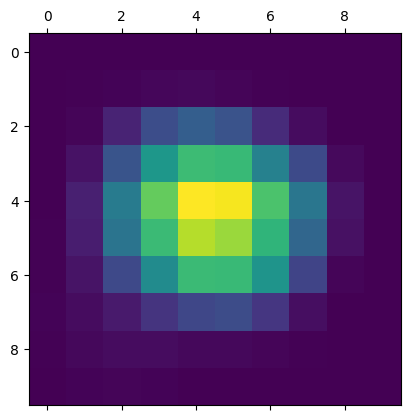

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=3)[0]) # Top3 da imagenet - Predição

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-8-918a449f54bc>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


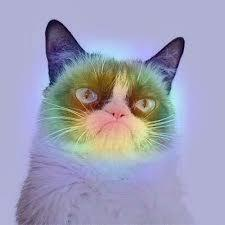

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cat.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# 🤖 Obrigada! 🤖